# Terrence Thesis - Case Study -- Without HOBs

### Import Statements

In [1]:
import flopy
import flopy.modflow as mf
import flopy.utils as fu
import flopy.utils.binaryfile as bf
import matplotlib as mpl 
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import platform
import shutil
import sys
import datetime
import math
from sklearn.metrics import mean_squared_error as mse

%matplotlib inline

### Setup folder where modflow-files are located

In [2]:
workspace = os.path.join('mf-data-without-hobs')

In [3]:
if os.path.exists(workspace):
    shutil.rmtree(workspace)

if not os.path.exists(workspace):
    os.makedirs(workspace)

### Print versions

In [4]:
print(sys.version)
print('numpy version: {}'.format(np.__version__))
print('matplotlib version: {}'.format(mpl.__version__))
print('flopy version: {}'.format(flopy.__version__))

3.6.3 (v3.6.3:2c5fed8, Oct  3 2017, 18:11:49) [MSC v.1900 64 bit (AMD64)]
numpy version: 1.14.3
matplotlib version: 2.1.1
flopy version: 3.2.9


### Setup MF-Package

In [5]:
modelname = 'model'
exe_name = 'mf2005'

if platform.system() == 'Windows':
    exe_name += '.exe'

In [6]:
tm = mf.Modflow(modelname=modelname, exe_name=exe_name, version='mf2005', model_ws=workspace)

### Setup Discretization Package

In [7]:
nrow = 1
ncol = 95
nlay = 10

Lx = 950
Ly = 25

botm = np.ones ( (nlay, nrow, ncol), dtype=np.int32 )
top = 33 * np.ones ( (nrow, ncol), dtype=np.int32 )

# Range does not include upper bound !!!
for i in range ( 30, 33):
    top[ :, i ] = 31
for i in range ( 47, 48 ):
    top[ :, i ] = 28
for i in range ( 50, 65):
    top[ :, i ] = 32

# N1 layer
botm[ 0, :, : ] = 28
for i in range ( 47, 49):
    botm[ 0, :, i ] = 28
# N2 layer46 
for i in range ( 0, 46):
    botm[ 1, :, i ] = 24
for i in range ( 46, 48 ):
    botm[ 1, :, i ] = 25
for i in range ( 48, 67 ):
    botm[ 1, :, i ] = 26
for i in range ( 67, ncol ):
    botm[ 1, :, i ] = 25
# N3 layer
for i in range ( 0, 33 ):
    botm[ 2, :, i ] = 20
for i in range ( 33, 46 ):
    botm[ 2, :, i ] = 21.5
for i in range ( 46, 48 ):
    botm[ 2, :, i ] = 24
for i in range ( 48, ncol ):
    botm[ 2, :, i ] = 24.5
# N4 layer
for i in range ( 0, 47 ):
    botm[ 3, :, i ] = 17
for i in range ( 47, 50 ):
    botm[ 3, :, i ] = 16
for i in range ( 50, 60 ):
    botm[ 3, :, i ] = 15
for i in range ( 60, ncol ):
    botm[ 3, :, i ] = 20
# N5 layer
for i in range ( 0, 50 ):
    botm[ 4, :, i ] = 15
for i in range ( 50, 60 ):
    botm[ 4, :, i ] = 14
for i in range ( 60, ncol ):
    botm[ 4, :, i ] = 16
# N6 layer
for i in range ( 0, 60 ):
    botm[ 5, :, i ] = 13
for i in range ( 60, ncol ):
    botm[ 5, :, i ] = 15
# 7 layer
botm[ 6, :, : ] = 10
# 8 layer
botm[ 7, :, : ] = 9
# 9 layer
botm[ 8, :, : ] = -12.5
# 10 layer
botm[ 9, :, : ] = -30

delr = Lx / ncol
delc = Ly / nrow
nper = 3521

perlen = 1
steady = np.full ( nper, False, dtype=bool )
steady[ 0 ] = True

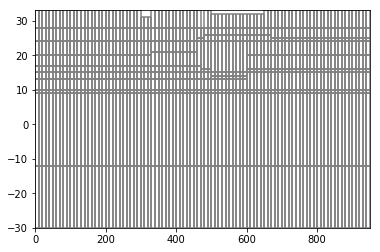

In [8]:
dis = mf.ModflowDis(
    tm, 
    nlay=nlay,
    nrow=nrow, 
    ncol=ncol, 
    delr=delr, 
    delc=delc, 
    top=top, 
    botm=botm, 
    nper=nper, 
    steady=steady
)

modelxsect= flopy.plot.ModelCrossSection(model=tm, line={'Row':0})
linecollection= modelxsect.plot_grid()

### Setup Basic-Package

Specify boundary conditions and starting heads.

We can set one value for all cells.

In [9]:
ibound = np.ones((nlay, nrow, ncol), dtype=np.int32)

for i in range ( 1, nlay ):
    ibound[ i, :, 0 ] = -1
    ibound[ i, :, -1 ] = -1

for k in range ( 47, 49 ):
    ibound[ 0, :, k ] = 0

strt = np.ones ( (nlay, nrow, ncol), dtype=np.int32 ) * 28
strt[ 1, :, 1 ] = 28
strt[ 1, :, -1 ] = 28

for i in range ( 30, 33 ):
    strt[ 0, :, i ] = 30
for j in range ( 50, 65 ):
    strt[ 0, :, j ] = 30
    
bas = mf.ModflowBas(tm, ibound=ibound, strt=strt)

#bas.plot()

### Setup Constant Head Boundaries

In [10]:
csv = pd.read_csv('SPA101.csv', delimiter=',')
chd_values = csv.iloc[ :, 2 ].values

#chd for each cell
#[lay, row, col, shead, ehead]
spchd = {}
spchd[0] = [
    [1, 0, 0, 28, 28 ], 
    [1, 0, ncol-1, 28, 28]
]

for layer in range (2, nlay):
    spchd[0].append ([layer, 0, 0, 28, 28 ])

for stress_period in range ( 1, nper ):
    spchd[stress_period] = [[1, 0, 0, chd_values[stress_period - 1], chd_values[stress_period]]]
    for layer in range (2, nlay):
        spchd[stress_period].append ([layer, 0, 0, chd_values[stress_period-1], chd_values[stress_period]])

chd = mf.ModflowChd(tm, stress_period_data=spchd)
#chd.plot()

### Setup General Head Boundaries

In [11]:
sp = {}
sp[0] = []
bas12_data = pd.read_csv ( 'Basin1&2.csv', delimiter=',' ).iloc[ :, 1 ].values
bas3_data = pd.read_csv ( 'Basin3.csv', delimiter=',' ).iloc[ :, 1 ].values

for col in range ( 30, 33 ):
    sp[ 0 ].append ( [ 0, 0, col, 31, 1450 ] )
    
for col in range ( 50, 65 ):
    sp[ 0 ].append ( [ 0, 0, col, 31, 1500 ] )
    
for stress_period in range ( 1,  nper ):
    sp[ stress_period ] = [ ]
    for col in range ( 30, 33 ):
        sp[ stress_period ].append ( [ 0, 0, col, 29 + 2.5*bas3_data[ stress_period - 1 ], 1800 ] )
    for col in range ( 50, 65 ):
        sp[ stress_period ].append ( [ 0, 0, col, 28.5 + 5*bas12_data[ stress_period - 1 ], 2000 ] )

ghb = mf.ModflowGhb (tm, stress_period_data=sp)
#ghb.plot()

### Setup Wells

In [12]:
# Pumping Well
wel_data = pd.read_csv('Pumping_well.csv', delimiter=',').iloc[:, -2].values

spwell = {}
spwell[0] = [8, 0, 41, 0]
for i in range(1, nper):
    spwell[i] = [8, 0, 41, -wel_data[i-1]]

wel = mf.ModflowWel(tm, stress_period_data=spwell, ipakcb=53)

#wel.plot()

### Setup Soil properties and Flow-Package

In [13]:
k1 = 2   # fine sand 1.728-7.776
k2 = 34  # middle sand 7.776-34.56
k3 = 41  # stone 34.56-103.68
k4 = 1   # clay
k5 = 45  # middle sand2
k6 = 6   # fine sand 1.728-7.776

# Set default hk-value value to k2
hk = np.ones((nlay, nrow, ncol)) * k2

# N1 layer
hk[0, :, :] = k1  # fine sand

# N2 layer
hk[1, :, :] = k2  # middle sand

# N3 layer
for i in range( 30, 60 ):
    hk[2, :, i] = k3  # sand & stone
for i in range( 55, 67 ):
    hk[2, :, i] = k4  # clay

#  N4 layer
hk[3, :, :] = k5  # middle sand2

# N5 layer
for i in range( 30, 44 ):
    hk[4, :, i] = k3  # sand & stone
for i in range( 44, 48 ):
    hk[4, :, i] = k4  # clay
for i in range( 48, 60 ):
    hk[4, :, i] = k3  # sand & stone
for i in range( 60, 65 ):
    hk[4, :, i] = k4  # clay

# N6 layer
hk[5, :, :] = k3
for i in range(36, 50 ):
    hk[5, :, i] = k6  # fine sand
for i in range( 50, 60 ):
    hk[5, :, i] = k3  # sand & stone
for i in range( 60, 65 ):
    hk[5, :, i] = k4  # clay

# 7 layer
hk[6, :, :] = k5  # middle sand2

# 8 layer
hk[7, :, :] = k5
for i in range(36 , 50 ):
    hk[7, :, i] = k6  # fine sand

# 9 layer
hk[8, :, :] = k5  # middle sand2

# 10 layer
hk[9, :, :] = k5  # middle sand2

# vertical HK
vk1 = 4
vk2 = 15
vk3 = 20
vk4 = 0.5
vk5 = 20
vk6 = 3

vka = np.ones((nlay, nrow, ncol), dtype=int) * vk3

# N1 layer
vka[0, :, :] = vk1  # fine sand

# N2 layer
vka[1, :, :] = vk2  # middle sand

# N3 layer
vka[2, :, :] = vk3
for i in range( 30, 55 ):
    vka[2, :, i] = vk3  # sand & stone
for i in range( 55, 67 ):
    vka[2, :, i] = vk4  # clay

# N4 layer
vka[3, :, :] = vk5  # middle sand2

# N5 layer
for i in range( 30, 44 ):
    vka[4, :, i] = vk3  # sand & stone
for i in range( 44, 48 ):
    vka[4, :, i] = vk4  # clay
for i in range( 48, 60 ):
    vka[4, :, i] = vk3  # sand & stone
for i in range( 60, 65 ):
    vka[4, :, i] = vk4  # clay

# N6 layer
vka[5, :, :] = vk3
for i in range( 36, 50 ):
    vka[5, :, i] = vk6  # fine sand
for i in range( 50, 60 ):
    vka[5, :, i] = vk3  # sand & stone
for i in range( 60, 65 ):
    vka[5, :, i] = vk4  # clay

# N7 layer
vka[6, :, :] = vk5  # middle sand2

# N8 layer
vka[7, :, :] = vk5
for i in range( 36, 50):
    vka[7, :, i] = vk6  # fine sand

# N9 layer
vka[8, :, :] = vk5  # middle sand2

# N10 layer
vka[9, :, :] = vk5  # middle sand2

laytyp = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
sy = 0.17
ss = 1e-4

lpf = mf.ModflowLpf(tm, laytyp=laytyp, hk=hk, layvka=0, vka=vka, sy=sy, ss=ss, ipakcb=53)

#lpf.plot()

### Setup Solver Package and Output-control with defaults

In [14]:
budgetfile = '{}.cbb'.format(modelname)
budget_filerecord = [budgetfile]

oc = mf.ModflowOc(tm, 
                   save_every=True,
                   save_types=['print head', 'print budget','print drawdown', 'save head', 'save budget','save drawdown'],
                   budget_filerecord=budget_filerecord,
                   compact=True
                  )

pcg = mf.ModflowPcg (tm, rclose=1e-1)

### Write Model input and run the model

In [15]:
tm.write_input()
success, buff = tm.run_model()

FloPy is using the following executable to run the model: C:\modflow\Packages\mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: model.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2018/10/04 14:19:27

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:     1    Gro

 Solving:  Stress period:   107    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   108    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   109    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   112    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   113    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   114    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   116    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   117    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   119    Time step:     1    Ground-Wa

 Solving:  Stress period:   220    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   221    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   222    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   223    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   224    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   225    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   226    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   227    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   228    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   229    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   230    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   231    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   232    Time step:     1    Ground-Wa

 Solving:  Stress period:   337    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   338    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   339    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   340    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   341    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   342    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   343    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   344    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   345    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   346    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   347    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   348    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   349    Time step:     1    Ground-Wa

 Solving:  Stress period:   464    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   465    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   466    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   467    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   468    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   469    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   470    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   471    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   472    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   473    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   474    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   475    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   476    Time step:     1    Ground-Wa

 Solving:  Stress period:   578    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   579    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   580    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   581    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   582    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   583    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   584    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   585    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   586    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   587    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   588    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   589    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   590    Time step:     1    Ground-Wa

 Solving:  Stress period:   687    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   688    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   689    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   690    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   691    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   692    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   693    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   694    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   695    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   696    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   697    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   698    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   699    Time step:     1    Ground-Wa

 Solving:  Stress period:   808    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   809    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   810    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   811    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   812    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   813    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   814    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   815    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   816    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   817    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   818    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   819    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   820    Time step:     1    Ground-Wa

 Solving:  Stress period:   923    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   924    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   925    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   926    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   927    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   928    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   929    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   930    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   931    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   932    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   933    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   934    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   935    Time step:     1    Ground-Wa

 Solving:  Stress period:  1029    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1030    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1031    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1032    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1033    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1034    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1035    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1036    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1037    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1038    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1039    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1040    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1041    Time step:     1    Ground-Wa

 Solving:  Stress period:  1152    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1153    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1154    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1155    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1156    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1157    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1158    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1159    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1160    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1161    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1162    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1163    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1164    Time step:     1    Ground-Wa

 Solving:  Stress period:  1262    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1263    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1264    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1265    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1266    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1267    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1268    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1269    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1270    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1271    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1272    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1273    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1274    Time step:     1    Ground-Wa

 Solving:  Stress period:  1379    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1380    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1381    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1382    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1383    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1384    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1385    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1386    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1387    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1388    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1389    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1390    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1391    Time step:     1    Ground-Wa

 Solving:  Stress period:  1499    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1500    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1501    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1502    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1503    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1504    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1505    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1506    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1507    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1508    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1509    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1510    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1511    Time step:     1    Ground-Wa

 Solving:  Stress period:  1619    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1620    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1621    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1622    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1623    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1624    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1625    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1626    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1627    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1628    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1629    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1630    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1631    Time step:     1    Ground-Wa

 Solving:  Stress period:  1736    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1737    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1738    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1739    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1740    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1741    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1742    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1743    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1744    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1745    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1746    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1747    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1748    Time step:     1    Ground-Wa

 Solving:  Stress period:  1856    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1857    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1858    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1859    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1860    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1861    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1862    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1863    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1864    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1865    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1866    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1867    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1868    Time step:     1    Ground-Wa

 Solving:  Stress period:  1978    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1979    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1980    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1981    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1982    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1983    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1984    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1985    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1986    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1987    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1988    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1989    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1990    Time step:     1    Ground-Wa

 Solving:  Stress period:  2084    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2085    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2086    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2087    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2088    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2089    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2090    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2091    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2092    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2093    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2094    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2095    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2096    Time step:     1    Ground-Wa

 Solving:  Stress period:  2203    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2204    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2205    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2206    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2207    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2208    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2209    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2210    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2211    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2212    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2213    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2214    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2215    Time step:     1    Ground-Wa

 Solving:  Stress period:  2321    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2322    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2323    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2324    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2325    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2326    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2327    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2328    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2329    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2330    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2331    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2332    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2333    Time step:     1    Ground-Wa

 Solving:  Stress period:  2433    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2434    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2435    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2436    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2437    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2438    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2439    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2440    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2441    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2442    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2443    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2444    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2445    Time step:     1    Ground-Wa

 Solving:  Stress period:  2550    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2551    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2552    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2553    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2554    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2555    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2556    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2557    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2558    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2559    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2560    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2561    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2562    Time step:     1    Ground-Wa

 Solving:  Stress period:  2667    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2668    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2669    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2670    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2671    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2672    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2673    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2674    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2675    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2676    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2677    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2678    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2679    Time step:     1    Ground-Wa

 Solving:  Stress period:  2785    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2786    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2787    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2788    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2789    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2790    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2791    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2792    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2793    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2794    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2795    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2796    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2797    Time step:     1    Ground-Wa

 Solving:  Stress period:  2898    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2899    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2900    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2901    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2902    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2903    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2904    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2905    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2906    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2907    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2908    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2909    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2910    Time step:     1    Ground-Wa

 Solving:  Stress period:  3023    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3024    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3025    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3026    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3027    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3028    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3029    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3030    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3031    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3032    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3033    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3034    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3035    Time step:     1    Ground-Wa

 Solving:  Stress period:  3137    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3138    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3139    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3140    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3141    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3142    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3143    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3144    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3145    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3146    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3147    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3148    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3149    Time step:     1    Ground-Wa

 Solving:  Stress period:  3248    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3249    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3250    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3251    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3252    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3253    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3254    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3255    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3256    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3257    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3258    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3259    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3260    Time step:     1    Ground-Wa

 Solving:  Stress period:  3373    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3374    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3375    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3376    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3377    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3378    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3379    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3380    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3381    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3382    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3383    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3384    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3385    Time step:     1    Ground-Wa

 Solving:  Stress period:  3497    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3498    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3499    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3500    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3501    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3502    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3503    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3504    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3505    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3506    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3507    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3508    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3509    Time step:     1    Ground-Wa

### Read Observations

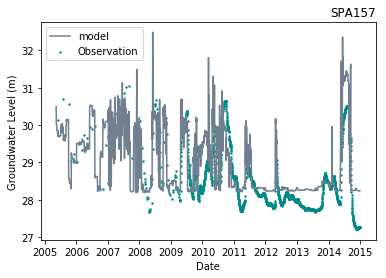

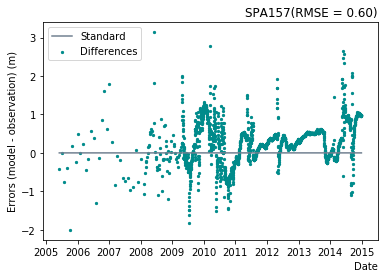

c:\python36\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


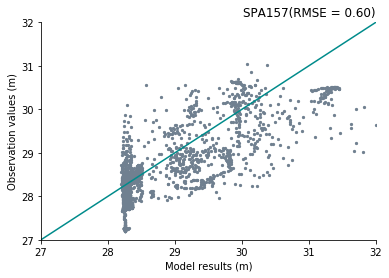

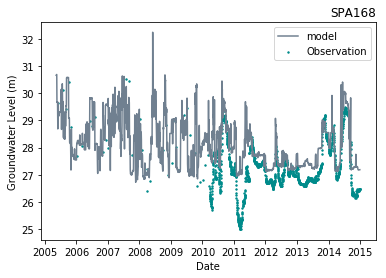

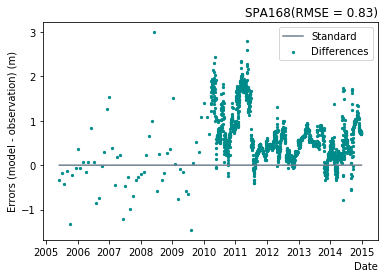

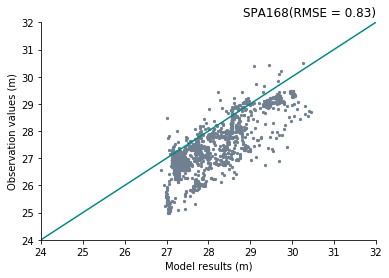

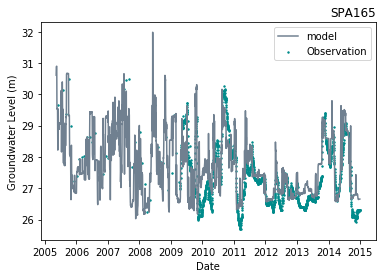

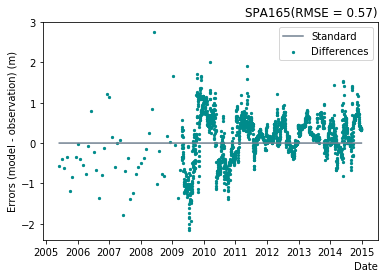

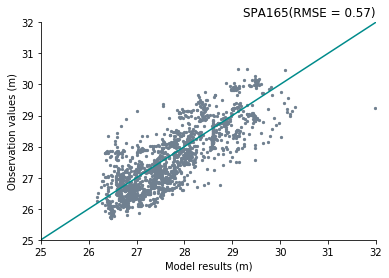

In [19]:
headobj = bf.HeadFile(os.path.join(workspace, modelname + '.hds'))

#observation wells

obs = [(1, 0, 65),
       (1, 0, 48),
       (1, 0, 46)]
name = ['SPA157','SPA168','SPA165']

for j in range (0,3):
    ts = headobj.get_ts ( idx= obs[j] )
    np.savetxt ( "HD.csv", ts, delimiter=',', header='Days,Head' )
    model = pd.read_csv ( 'HD.csv',delimiter=',')

    time = model.iloc[:,0].values
    head = model.iloc[:,1].values
    q1 = []
    for i in time:
        q1.append([datetime.date(2005,5,11)+datetime.timedelta(i-1)])
    observation = pd.read_csv ( name[j]+'.csv' , delimiter=',' )
    x = pd.merge ( model, observation,
               left_on='# Days',
               right_on='# Days',
               how='inner'
               )
    
    time = x.iloc[ :, 0 ].values
    q = []
    for i in time:
        q.append([datetime.date(2005,5,11)+datetime.timedelta(i-1)])
    h1 = x.iloc[ :, 1 ].values
    h2 = x.iloc[ :, 2 ].values

    plt.plot ( q1, head, label='model' , c = 'slategray')
    plt.scatter ( q, h2, label='Observation', s=2,c='darkcyan' )
    plt.legend ( [ "model", "Observation" ] )
    plt.xlabel ( 'Date' )
    plt.ylabel ( 'Groundwater Level (m)' )
    plt.title ( name[j] , loc='right' )
    plt.show ()


    rmse = math.sqrt ( mse ( h1, h2 ) )
    rmse = '{:01.2f}'.format(rmse)
    u = []
    u = h1-h2
    a = h1 - h1
    plt.plot(q,a,c='slategray',label='Standard')
    plt.scatter(q,u,s=5,label='Differences',c = 'darkcyan')
    plt.legend(['Standard','Differences'])
    plt.xlabel('Date',horizontalalignment='right',x=1.0)
    plt.ylabel('Errors (model - observation) (m)')
    plt.title( name[j] + '(RMSE = ' + str ( rmse )+')', loc='right')
    plt.show()


    x = [int(min(h2)),32]
    y = [int(min(h2)),32]
    plt.scatter(h1,h2,s = 5,c='slategray')
    plt.plot(x,y,c='darkcyan')
    plt.ylim(int(min(h2)),32)
    plt.xlim(int(min(h2)),32)
    plt.xlabel('Model results (m)')
    plt.ylabel('Observation values (m)')
    plt.subplot().spines['right'].set_color('none')
    plt.subplot().spines['top'].set_color('none')
    plt.subplot()
    plt.title(name[j] + '(RMSE = ' + str ( rmse )+')', loc='right')
    plt.show()
    
    os.remove('HD.csv')

